In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize

In [432]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True)
cleaned = mne.io.read_epochs_eeglab(processed_file)

raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=40)
raw_down_sampled = raw_lowpass.copy().resample(sfreq=256)


raw_down_sampled.drop_channels(['P8', 'P10', 'PO8', 'F2'])

raw_down_sampled.set_montage('biosemi64')

mne.set_eeg_reference(raw_down_sampled)

Extracting EDF parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro\sub-001_ses-t1_task-resteyesc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245759  =      0.000 ...   239.999 secs...
Extracting parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned\sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


(<RawEDF | sub-001_ses-t1_task-resteyesc_eeg.edf, 60 x 61440 (240.0 s), ~28.2 MB, data loaded>,
 array([ 4.09081928e-11,  7.95202813e-08,  8.20969546e-08, ...,
        -1.66411560e-08,  1.86106153e-08,  1.93828690e-08]))

In [433]:
gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)
print(gfp_peakes.get_data().shape)
top_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -gfp_peakes.get_data().shape[1])[-gfp_peakes.get_data().shape[1]:]
print(top_indices.shape)
gfp_data = gfp_peakes.get_data()[:, top_indices]
print(gfp_data.shape)

(60, 5983)
(5983,)
(60, 5983)


In [434]:
normalized = unit_normalize(gfp_data.T)
activation = normalized.dot(normalized.T)
absolute_cosine_matrix = np.abs(activation)
#np.fill_diagonal(absolute_cosine_matrix, 0)
print(absolute_cosine_matrix.shape)
distance_matrix = np.abs(absolute_cosine_matrix - 1)

(5983, 5983)


In [435]:
cluster = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2)
cluster.fit(distance_matrix)

HDBSCAN(metric='precomputed', min_samples=2)

In [436]:
print(cluster.algorithm)

best


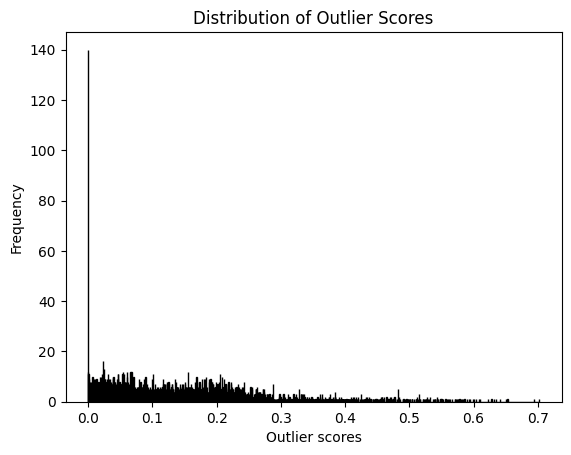

In [437]:
plt.hist(cluster.outlier_scores_, bins=3500, edgecolor='k')
plt.xlabel('Outlier scores')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.show()

In [438]:
cluster.leaf_size

40

In [439]:
cluster.cluster_persistence_

array([0.00123348, 0.00089335, 0.00115152, 0.00623323, 0.        ])

<Axes: ylabel='$\\lambda$ value'>

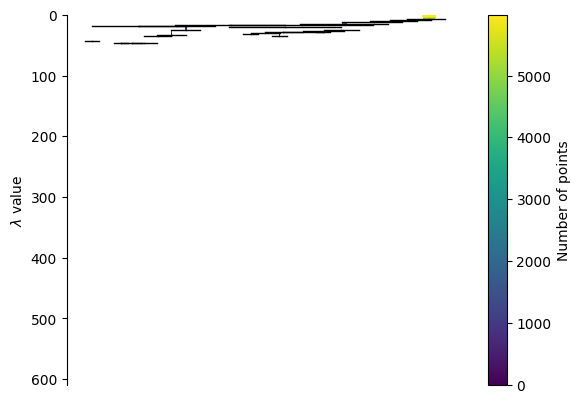

In [440]:
cluster.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

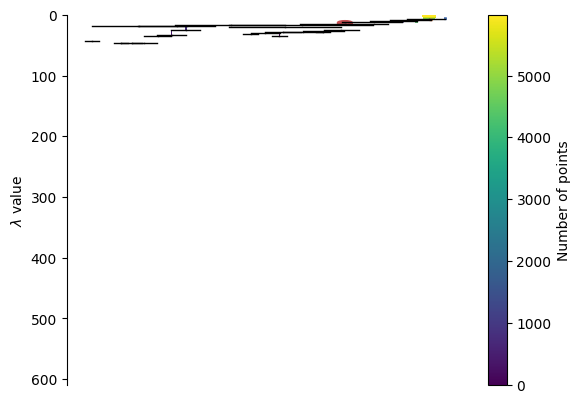

In [441]:
cluster.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [442]:
g = cluster.condensed_tree_.to_networkx()
g.number_of_nodes()

6034

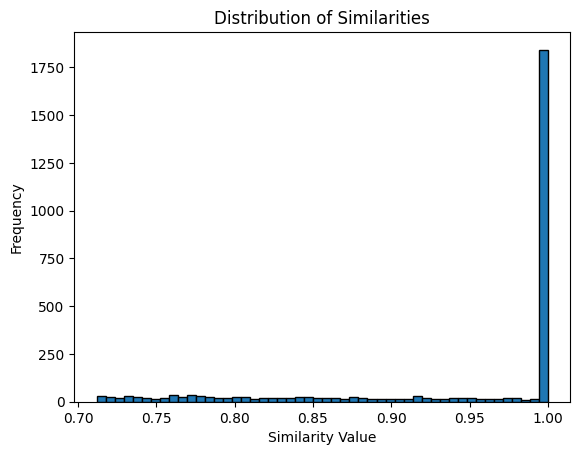

In [443]:
plt.hist(cluster.probabilities_[np.where(cluster.probabilities_>0)], bins=50, edgecolor='k')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')
plt.show()

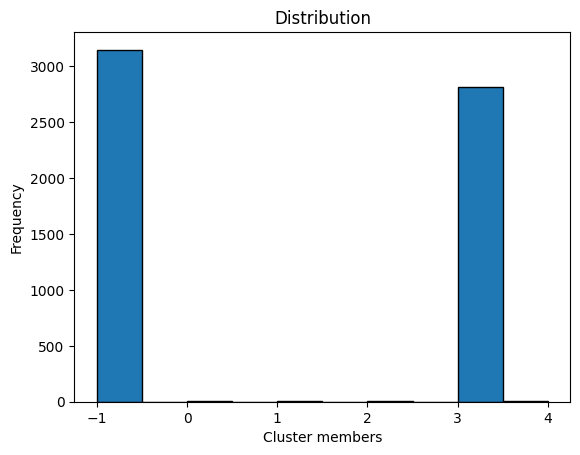

In [444]:
plt.hist(cluster.labels_, bins=10, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

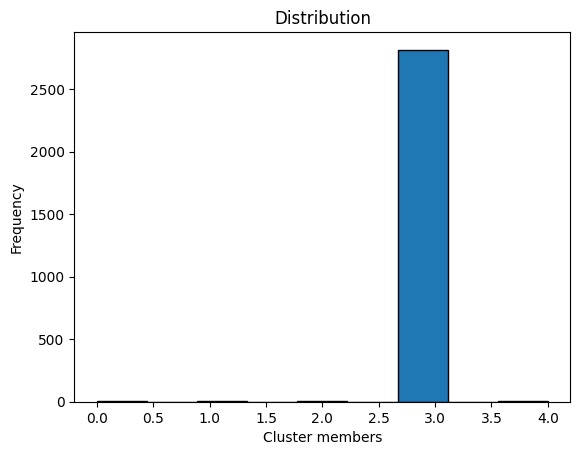

In [445]:
plt.hist(cluster.labels_[np.where(cluster.labels_>-1)], bins=9, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

(5983, 60)
(1, 2814, 60)
(1, 60)


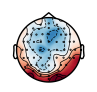

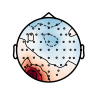

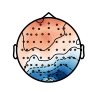

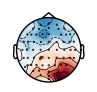

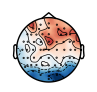

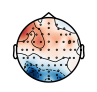

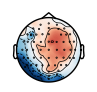

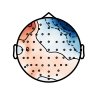

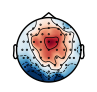

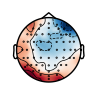

(<matplotlib.image.AxesImage at 0x259258c2950>,
 <matplotlib.contour.QuadContourSet at 0x259258c2500>)

In [448]:
c11_indexes = np.where(cluster.labels_==3)
print(normalized.shape)
c11_gfp = normalized[c11_indexes, :]
print(c11_gfp.shape)
c11_gfp.reshape((2814, 60))
print(c11_gfp[:, 0].shape)
mne.viz.plot_topomap(c11_gfp[:, 0].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 10].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 2400].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 87].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 103].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 509].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 654].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 899].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 1000].flatten(), pos=raw_down_sampled.info)
mne.viz.plot_topomap(c11_gfp[:, 1199].flatten(), pos=raw_down_sampled.info)
